In [32]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [33]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full_corrected.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'plasma_labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full_corrected.csv
Name of the anagraphic dataset: plasma_labels.csv


In [34]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    lbls[feat_to_predict] = lbls[feat_to_predict].map(lambda x: np.nan if x==' ' else x)
    lbls = lbls.dropna()
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    temp[feat_to_predict] = temp[feat_to_predict].astype(int)
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    return data, labels

In [35]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [36]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [37]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [38]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(1000):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### Audio

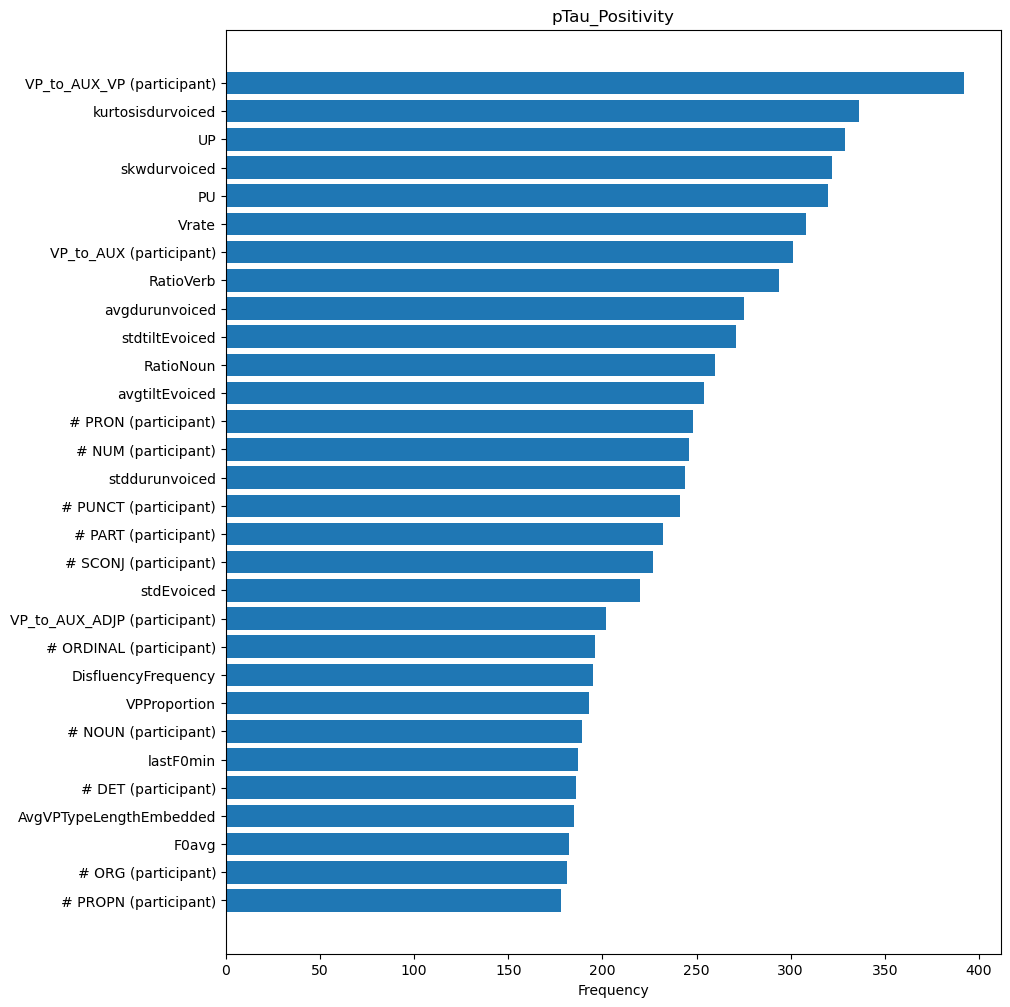

VP_to_AUX_VP (participant), kurtosisdurvoiced, UP, skwdurvoiced, PU,
Vrate, VP_to_AUX (participant), RatioVerb, avgdurunvoiced, stdtiltEvoiced,
RatioNoun, avgtiltEvoiced, # PRON (participant), # NUM (participant), stddurunvoiced,
# PUNCT (participant), # PART (participant), # SCONJ (participant), stdEvoiced, VP_to_AUX_ADJP (participant),
# ORDINAL (participant), DisfluencyFrequency, VPProportion, # NOUN (participant), lastF0min,
# DET (participant), AvgVPTypeLengthEmbedded, F0avg, # ORG (participant), # PROPN (participant),


In [47]:
TTAU_ML_FULL_COMPUTED_FEATURES = ml_analysis('pTau_Positivity')

### No Audio

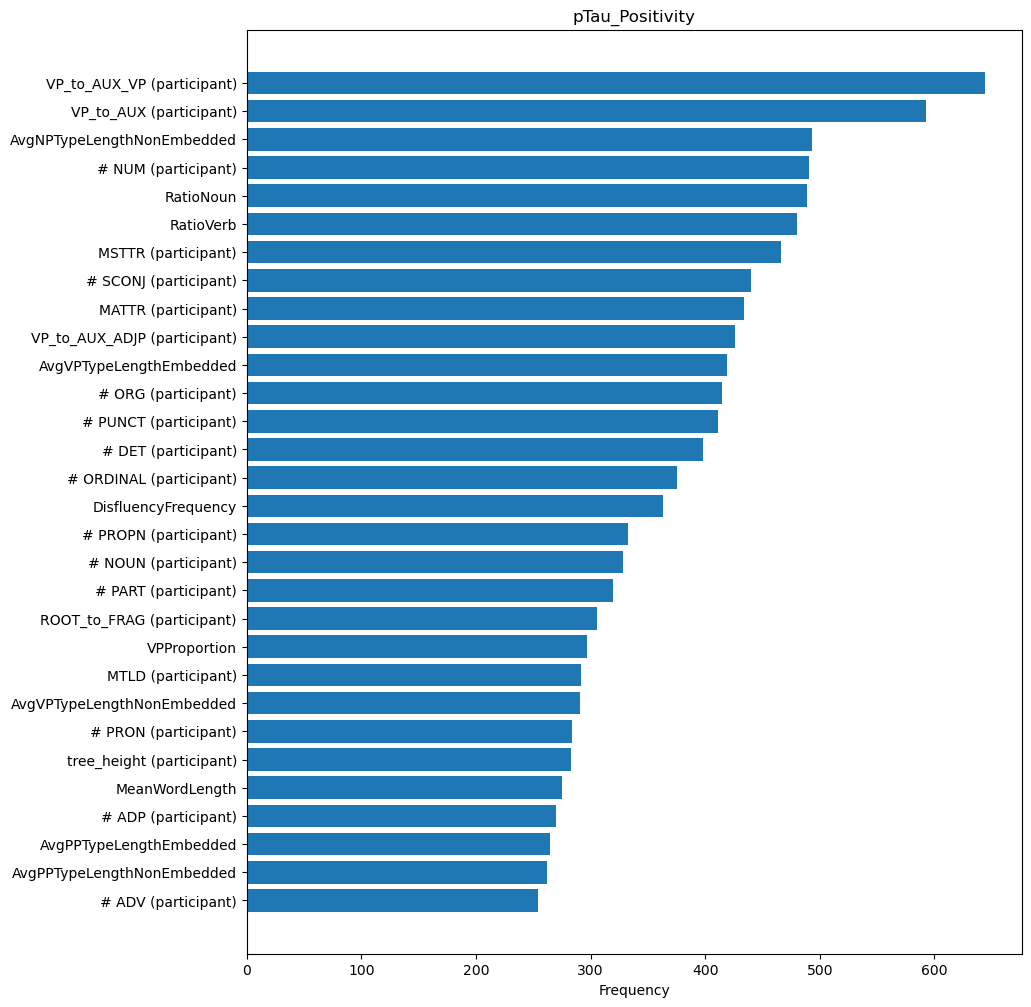

VP_to_AUX_VP (participant), VP_to_AUX (participant), AvgNPTypeLengthNonEmbedded, # NUM (participant), RatioNoun,
RatioVerb, MSTTR (participant), # SCONJ (participant), MATTR (participant), VP_to_AUX_ADJP (participant),
AvgVPTypeLengthEmbedded, # ORG (participant), # PUNCT (participant), # DET (participant), # ORDINAL (participant),
DisfluencyFrequency, # PROPN (participant), # NOUN (participant), # PART (participant), ROOT_to_FRAG (participant),
VPProportion, MTLD (participant), AvgVPTypeLengthNonEmbedded, # PRON (participant), tree_height (participant),
MeanWordLength, # ADP (participant), AvgPPTypeLengthEmbedded, AvgPPTypeLengthNonEmbedded, # ADV (participant),


In [8]:
TTAU_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('pTau_Positivity', audio=False)

# Statistical Approach

In [40]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [41]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Audio

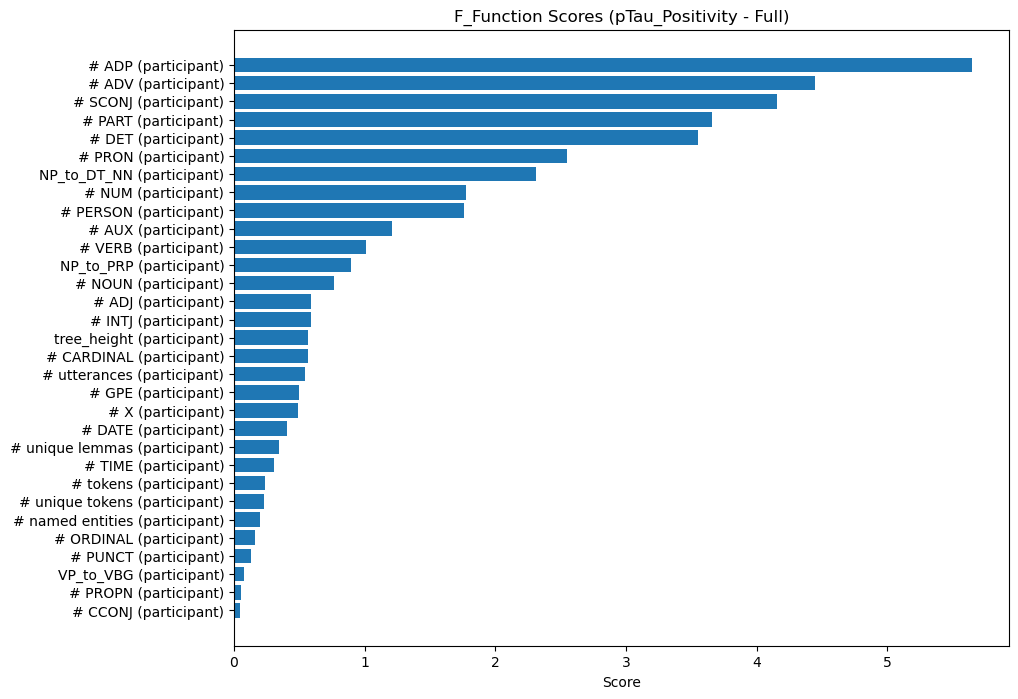

# ADP (participant), # ADV (participant), # SCONJ (participant), # PART (participant), # DET (participant),
# PRON (participant), NP_to_DT_NN (participant), # NUM (participant), # PERSON (participant), # AUX (participant),
# VERB (participant), NP_to_PRP (participant), # NOUN (participant), # ADJ (participant), # INTJ (participant),
tree_height (participant), # CARDINAL (participant), # utterances (participant), # GPE (participant), # X (participant),
# DATE (participant), # unique lemmas (participant), # TIME (participant), # tokens (participant), # unique tokens (participant),
# named entities (participant), # ORDINAL (participant), # PUNCT (participant), VP_to_VBG (participant), # PROPN (participant),
# CCONJ (participant)


In [42]:
TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('pTau_Positivity')

### No Audio

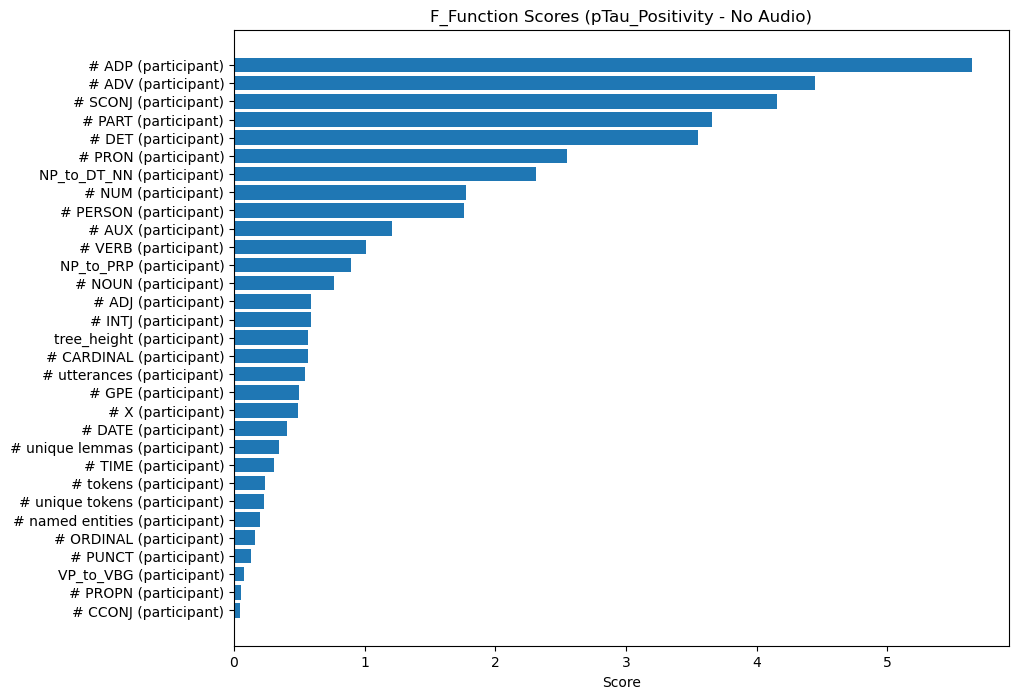

# ADP (participant), # ADV (participant), # SCONJ (participant), # PART (participant), # DET (participant),
# PRON (participant), NP_to_DT_NN (participant), # NUM (participant), # PERSON (participant), # AUX (participant),
# VERB (participant), NP_to_PRP (participant), # NOUN (participant), # ADJ (participant), # INTJ (participant),
tree_height (participant), # CARDINAL (participant), # utterances (participant), # GPE (participant), # X (participant),
# DATE (participant), # unique lemmas (participant), # TIME (participant), # tokens (participant), # unique tokens (participant),
# named entities (participant), # ORDINAL (participant), # PUNCT (participant), VP_to_VBG (participant), # PROPN (participant),
# CCONJ (participant)


In [11]:
TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('pTau_Positivity', audio=False)

## Mutual Information

In [45]:
def m_info(to_predict, runs=1000, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### Audio

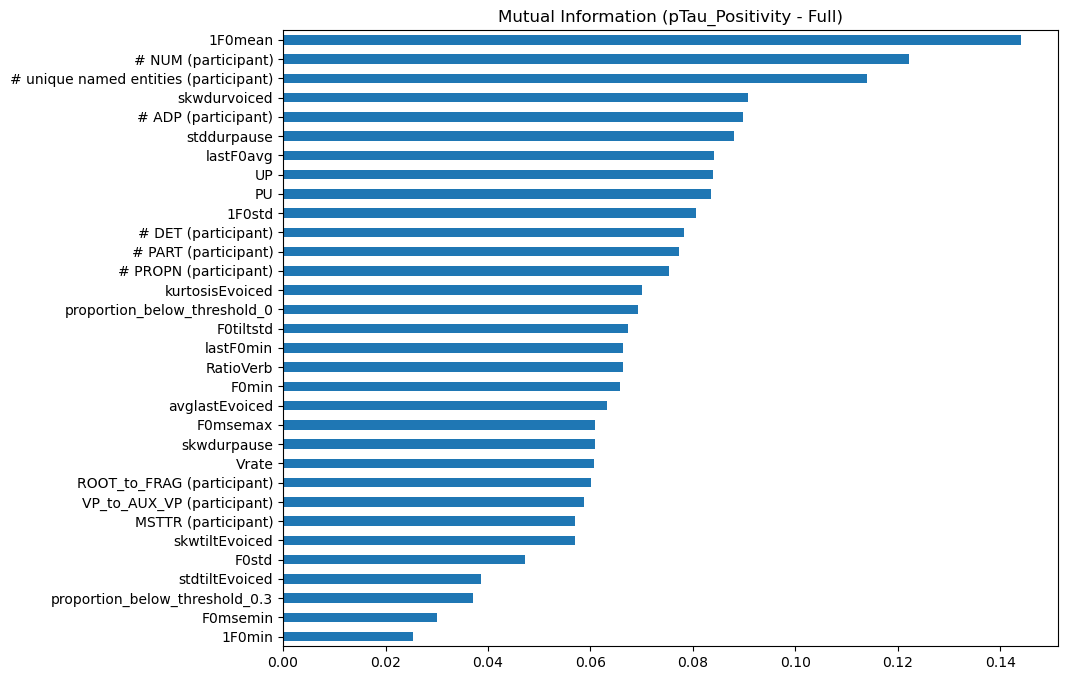

1F0mean, # NUM (participant), # unique named entities (participant), skwdurvoiced, # ADP (participant),
stddurpause, lastF0avg, UP, PU, 1F0std,
# DET (participant), # PART (participant), # PROPN (participant), kurtosisEvoiced, proportion_below_threshold_0,
F0tiltstd, lastF0min, RatioVerb, F0min, avglastEvoiced,
F0msemax, skwdurpause, Vrate, ROOT_to_FRAG (participant), VP_to_AUX_VP (participant),
MSTTR (participant), skwtiltEvoiced, F0std, stdtiltEvoiced, proportion_below_threshold_0.3,
F0msemin, 1F0min


In [46]:
TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('pTau_Positivity')

### No Audio

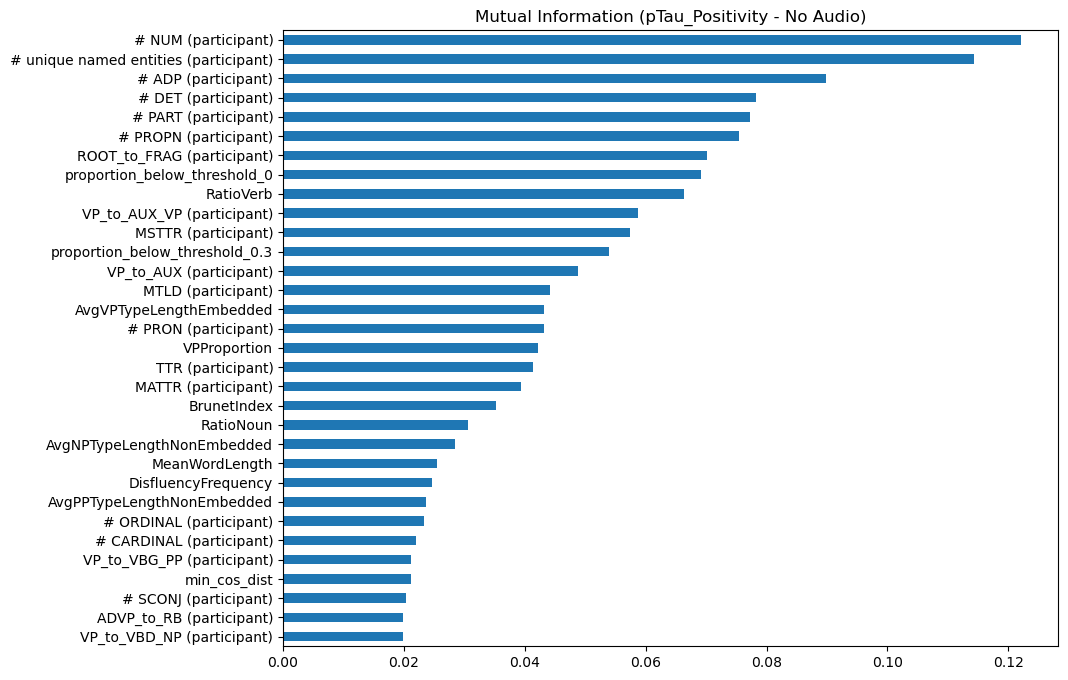

# NUM (participant), # unique named entities (participant), # ADP (participant), # DET (participant), # PART (participant),
# PROPN (participant), ROOT_to_FRAG (participant), proportion_below_threshold_0, RatioVerb, VP_to_AUX_VP (participant),
MSTTR (participant), proportion_below_threshold_0.3, VP_to_AUX (participant), MTLD (participant), AvgVPTypeLengthEmbedded,
# PRON (participant), VPProportion, TTR (participant), MATTR (participant), BrunetIndex,
RatioNoun, AvgNPTypeLengthNonEmbedded, MeanWordLength, DisfluencyFrequency, AvgPPTypeLengthNonEmbedded,
# ORDINAL (participant), # CARDINAL (participant), VP_to_VBG_PP (participant), min_cos_dist, # SCONJ (participant),
ADVP_to_RB (participant), VP_to_VBD_NP (participant)


In [13]:
TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('pTau_Positivity', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [50]:
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s, mean_rocs = [], [], []
    stdev_accs, stdev_f1s, stdev_rocs = [], [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s, rocs = [], [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test['pTau_Positivity'], y_pred))
            f1s.append(f1_score(y_test['pTau_Positivity'], y_pred))
            rocs.append(roc_auc_score(y_test['pTau_Positivity'], y_pred))

        mean_accs.append(np.mean(accs)), mean_f1s.append(np.mean(f1s)), mean_rocs.append(np.mean(rocs))
        stdev_accs.append(np.std(accs)), stdev_f1s.append(np.std(f1s)), stdev_rocs.append(np.std(rocs))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s), (mean_rocs, stdev_rocs)


In [51]:
def plot_metrics(accs, f1s, rocs, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(132)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(133)
    plt.title('Average ROC-AUC Score')
    plt.plot(x_axis, rocs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy: {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score: {f1s[0][idx]} +- {f1s[1][idx]}')
        print(f'ROC-AUC:  {rocs[0][idx]} +- {rocs[1][idx]}\n')

### pTau_Positivity (Full)

In [52]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME)
X_ttau_audio, y_ttau_audio = load_raw_data(PATH, 'pTau_Positivity')

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


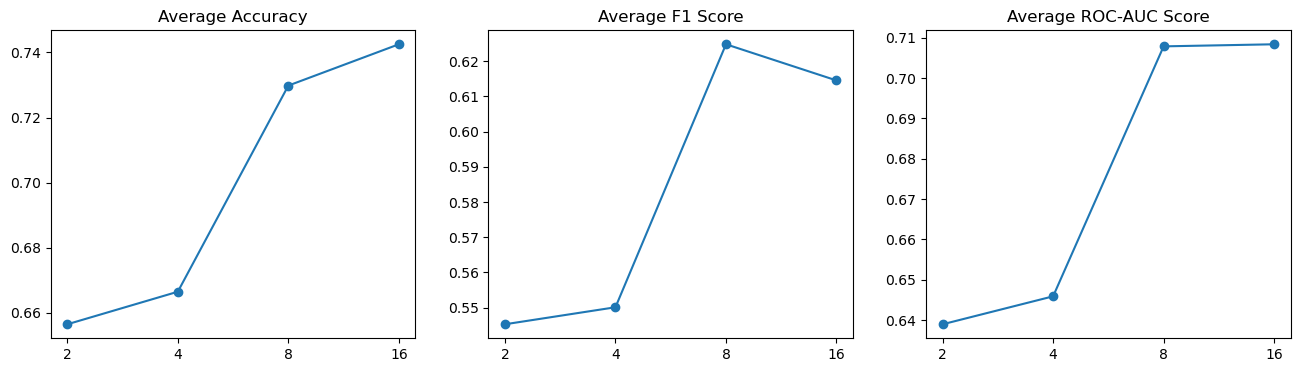

**********   Top 2   **********
Accuracy: 0.6565 +- 0.10413302790181411
F1 Score: 0.5452903344075946 +- 0.15085743065688326
F1 Score: 0.6389666666666667 +- 0.6389666666666667

**********   Top 4   **********
Accuracy: 0.6665 +- 0.10794790410193243
F1 Score: 0.5501233574818714 +- 0.1524849285328342
F1 Score: 0.6459 +- 0.6459

**********   Top 8   **********
Accuracy: 0.7298125 +- 0.09946479826426029
F1 Score: 0.6248043307483709 +- 0.1478799954924494
F1 Score: 0.7078833333333333 +- 0.7078833333333333

**********   Top 16   **********
Accuracy: 0.7425 +- 0.09269405320731205
F1 Score: 0.6145345554772025 +- 0.15334370841309122
F1 Score: 0.7083999999999999 +- 0.7083999999999999



In [53]:
ttau_ml_feats_audio = TTAU_ML_FULL_COMPUTED_FEATURES[:]

ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio, ttau_ml_feats_audio)

#### Statistical Approach (F_classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


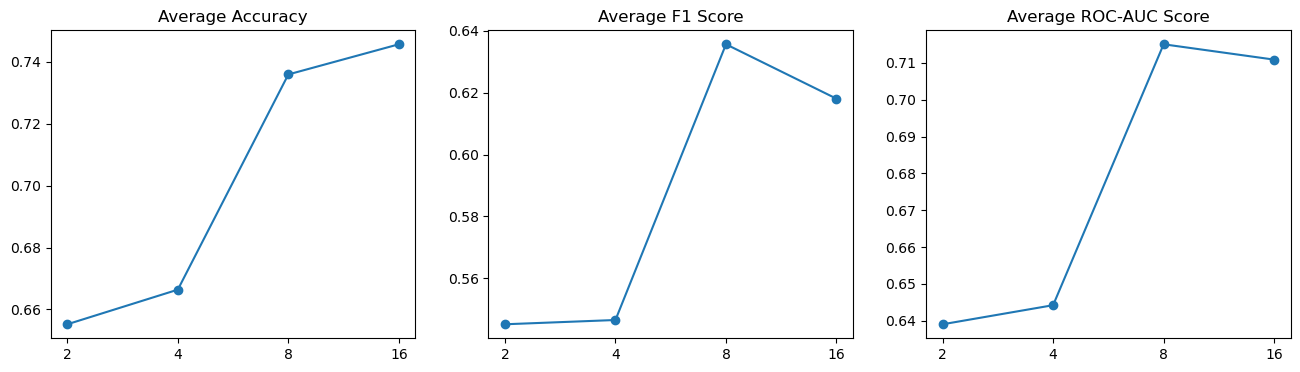

**********   Top 2   **********
Accuracy: 0.6551875 +- 0.10420290827875198
F1 Score: 0.5450894101426609 +- 0.15173977355666948
F1 Score: 0.6390166666666667 +- 0.6390166666666667

**********   Top 4   **********
Accuracy: 0.666375 +- 0.10617195663168312
F1 Score: 0.5464706675161783 +- 0.15423935615533324
F1 Score: 0.6442 +- 0.6442

**********   Top 8   **********
Accuracy: 0.7359375 +- 0.10020243182553006
F1 Score: 0.6356593556770026 +- 0.14530136973830168
F1 Score: 0.7150500000000001 +- 0.7150500000000001

**********   Top 16   **********
Accuracy: 0.7456875 +- 0.09874681561321356
F1 Score: 0.6180527306027306 +- 0.16078102104787373
F1 Score: 0.7108833333333333 +- 0.7108833333333333



In [54]:
ttau_f_classif_feats_audio = TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES[:]

ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio, ttau_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


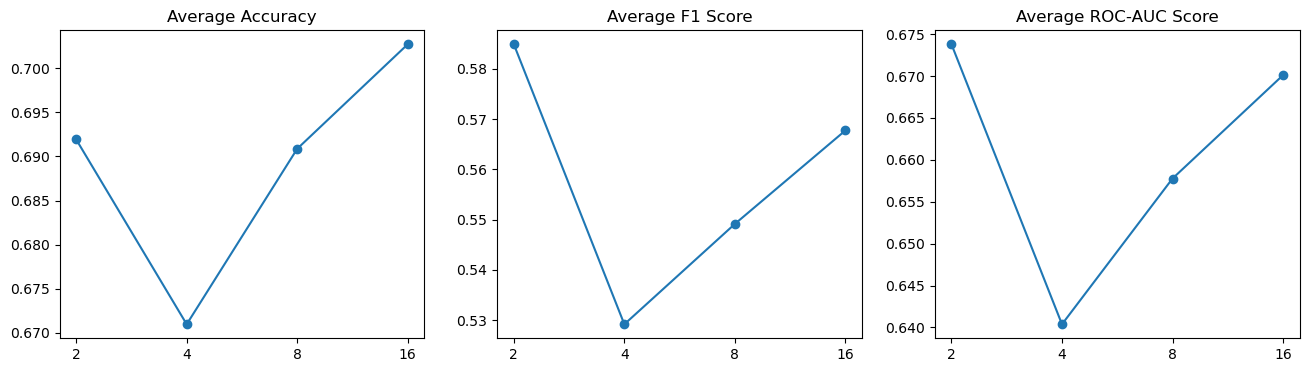

**********   Top 2   **********
Accuracy: 0.6919375 +- 0.10932961558402188
F1 Score: 0.5848780498655111 +- 0.1582631756926333
F1 Score: 0.6737833333333333 +- 0.6737833333333333

**********   Top 4   **********
Accuracy: 0.6709375 +- 0.10244615582709779
F1 Score: 0.529157941731471 +- 0.1666309982216115
F1 Score: 0.6403833333333333 +- 0.6403833333333333

**********   Top 8   **********
Accuracy: 0.690875 +- 0.10321178166759841
F1 Score: 0.5491222140604494 +- 0.1621377489784588
F1 Score: 0.6577666666666666 +- 0.6577666666666666

**********   Top 16   **********
Accuracy: 0.70275 +- 0.10301061838470829
F1 Score: 0.5677236268633328 +- 0.15948169938474016
F1 Score: 0.6700999999999999 +- 0.6700999999999999



In [55]:
ttau_mutual_info_feats_audio = TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_mutual_info_feats_audio)
plot_metrics(ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio, ttau_mutual_info_feats_audio)

### pTau_Positivity (No Audio)

In [18]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)
X_ttau, y_ttau = load_raw_data(PATH, 'pTau_Positivity')

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


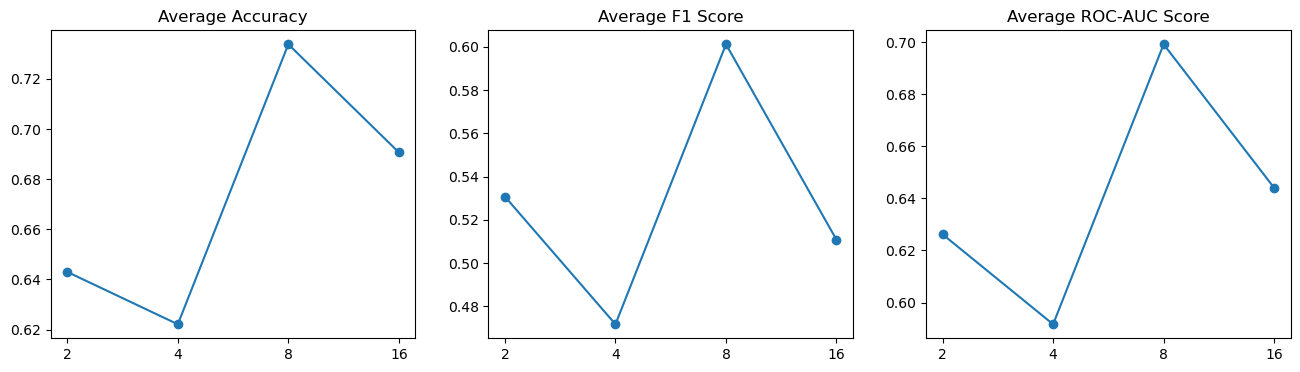

**********   Top 2   **********
Accuracy: 0.643 +- 0.10659971857373733
F1 Score: 0.5307529660569907 +- 0.1506839329974202
F1 Score: 0.6262000000000001 +- 0.6262000000000001

**********   Top 4   **********
Accuracy: 0.622125 +- 0.1023146953032652
F1 Score: 0.47171903194844367 +- 0.15663891438651312
F1 Score: 0.5916666666666667 +- 0.5916666666666667

**********   Top 8   **********
Accuracy: 0.7338125 +- 0.09826461007784033
F1 Score: 0.6012234806043629 +- 0.16284504185881457
F1 Score: 0.6991833333333333 +- 0.6991833333333333

**********   Top 16   **********
Accuracy: 0.6906875 +- 0.1040282225828645
F1 Score: 0.5108054466775054 +- 0.18565164574250018
F1 Score: 0.6440499999999999 +- 0.6440499999999999



In [19]:
ttau_ml_feats = [
    'VP_to_AUX_VP (participant)', 'VP_to_AUX (participant)', 'AvgNPTypeLengthNonEmbedded', '# NUM (participant)', 'RatioNoun',
    'RatioVerb', 'MSTTR (participant)', '# SCONJ (participant)', 'MATTR (participant)', 'VP_to_AUX_ADJP (participant)',
    'AvgVPTypeLengthEmbedded', '# ORG (participant)', '# PUNCT (participant)', '# DET (participant)', '# ORDINAL (participant)',
    'DisfluencyFrequency', '# PROPN (participant)', '# NOUN (participant)', '# PART (participant)', 'ROOT_to_FRAG (participant)',
    'VPProportion', 'MTLD (participant)', 'AvgVPTypeLengthNonEmbedded', '# PRON (participant)', 'tree_height (participant)',
    'MeanWordLength', '# ADP (participant)', 'AvgPPTypeLengthEmbedded', 'AvgPPTypeLengthNonEmbedded', '# ADV (participant)'
]#TTAU_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs, ttau_ml_feats)

In [20]:
ttau_ml_feats[:8]

['VP_to_AUX_VP (participant)',
 'VP_to_AUX (participant)',
 'AvgNPTypeLengthNonEmbedded',
 '# NUM (participant)',
 'RatioNoun',
 'RatioVerb',
 'MSTTR (participant)',
 '# SCONJ (participant)']

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


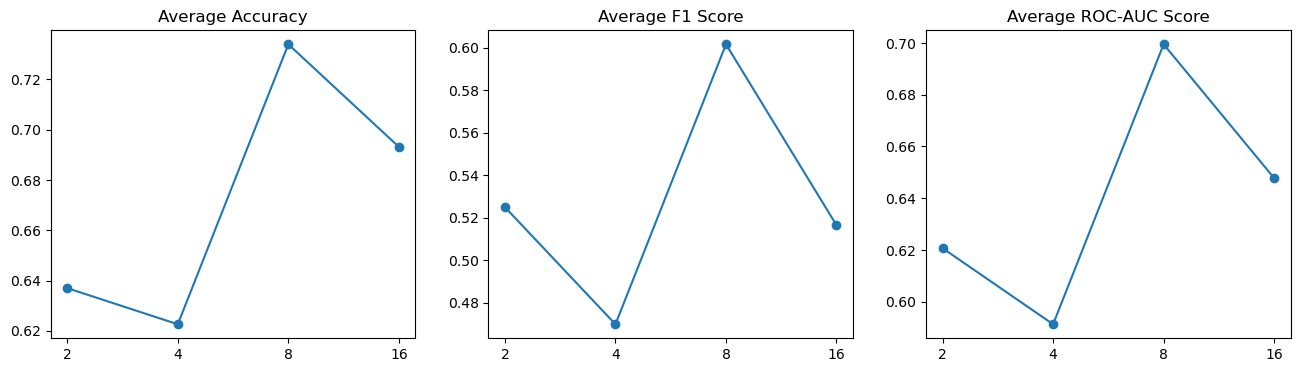

**********   Top 2   **********
Accuracy: 0.637 +- 0.10920765769853322
F1 Score: 0.5249377742226814 +- 0.153900777785316
F1 Score: 0.6206999999999999 +- 0.6206999999999999

**********   Top 4   **********
Accuracy: 0.622625 +- 0.099815376445716
F1 Score: 0.4697937456334515 +- 0.15446813674704152
F1 Score: 0.5912999999999999 +- 0.5912999999999999

**********   Top 8   **********
Accuracy: 0.734 +- 0.09918543239810974
F1 Score: 0.6016316773096184 +- 0.16584639511307234
F1 Score: 0.6995 +- 0.6995

**********   Top 16   **********
Accuracy: 0.6931875 +- 0.10183317776515667
F1 Score: 0.5164386708063178 +- 0.18403619274323016
F1 Score: 0.6477833333333333 +- 0.6477833333333333



In [21]:
ttau_f_classif_feats = [
    '# ADP (participant)', '# ADV (participant)', '# SCONJ (participant)', '# PART (participant)', '# DET (participant)',
    '# PRON (participant)', 'NP_to_DT_NN (participant)', '# NUM (participant)', '# PERSON (participant)', '# AUX (participant)',
    '# VERB (participant)', 'NP_to_PRP (participant)', '# NOUN (participant)', '# ADJ (participant)', '# INTJ (participant)',
    'tree_height (participant)', '# CARDINAL (participant)', '# utterances (participant)', '# GPE (participant)', '# X (participant)',
    '# DATE (participant)', '# unique lemmas (participant)', '# TIME (participant)', '# tokens (participant)', '# unique tokens (participant)',
    '# named entities (participant)', '# ORDINAL (participant)', '# PUNCT (participant)', 'VP_to_VBG (participant)', '# PROPN (participant)',
    '# CCONJ (participant)'
]#TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs, ttau_f_classif_feats)

In [22]:
ttau_f_classif_feats[:8]

['# ADP (participant)',
 '# ADV (participant)',
 '# SCONJ (participant)',
 '# PART (participant)',
 '# DET (participant)',
 '# PRON (participant)',
 'NP_to_DT_NN (participant)',
 '# NUM (participant)']

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:23<00:00,  4.93it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:28<00:00,  4.81it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


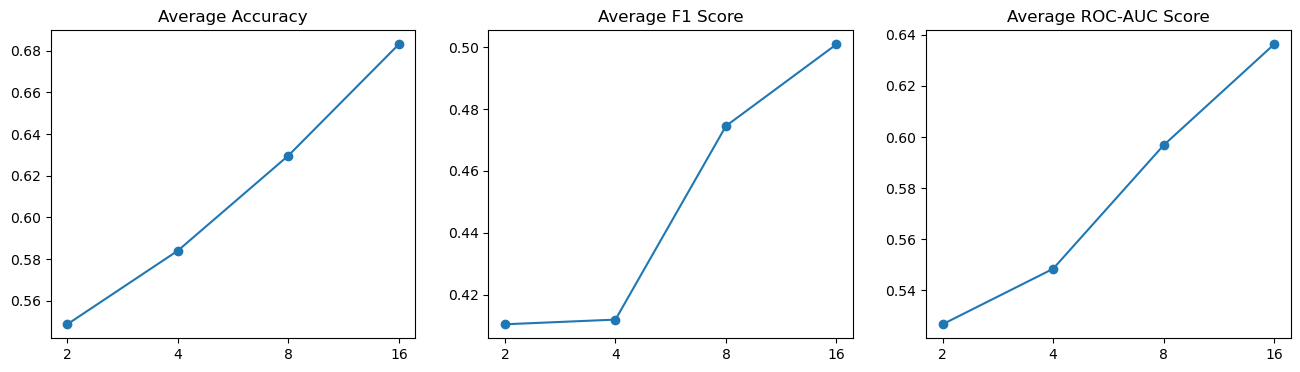

**********   Top 2   **********
Accuracy: 0.5486875 +- 0.11575430270080678
F1 Score: 0.41041233096968394 +- 0.16257333862810433
F1 Score: 0.5266833333333334 +- 0.5266833333333334

**********   Top 4   **********
Accuracy: 0.584 +- 0.11284087247092696
F1 Score: 0.4119224801342448 +- 0.16670690365951923
F1 Score: 0.5484 +- 0.5484

**********   Top 8   **********
Accuracy: 0.629625 +- 0.10815433128173832
F1 Score: 0.47450230455818687 +- 0.16602479274918974
F1 Score: 0.5967666666666667 +- 0.5967666666666667

**********   Top 16   **********
Accuracy: 0.6830625 +- 0.10465641329488604
F1 Score: 0.5009070818070819 +- 0.18154741353137668
F1 Score: 0.6362833333333333 +- 0.6362833333333333



In [23]:
ttau_mutual_info_feats = [
    '# NUM (participant)', '# unique named entities (participant)', '# ADP (participant)', '# DET (participant)', '# PART (participant)',
    '# PROPN (participant)', 'ROOT_to_FRAG (participant)', 'proportion_below_threshold_0', 'RatioVerb', 'VP_to_AUX_VP (participant)',
    'MSTTR (participant)', 'proportion_below_threshold_0.3', 'VP_to_AUX (participant)', 'MTLD (participant)', 'AvgVPTypeLengthEmbedded',
    '# PRON (participant)',' VPProportion', 'TTR (participant)', 'MATTR (participant)', 'BrunetIndex',
    'RatioNoun', 'AvgNPTypeLengthNonEmbedded', 'MeanWordLength', 'DisfluencyFrequency', 'AvgPPTypeLengthNonEmbedded',
    '# ORDINAL (participant)', '# CARDINAL (participant)', 'VP_to_VBG_PP (participant)', 'min_cos_dist', '# SCONJ (participant)',
    'ADVP_to_RB (participant)', 'VP_to_VBD_NP (participant)'
]#TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_metrics(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs, ttau_mutual_info_feats)

In [25]:
ttau_mix_features = []
a, b = ttau_ml_feats[:8], ttau_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ttau_mix_features:
            ttau_mix_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ttau_mix_features:
            ttau_mix_features.append(b[idx])

ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs = check_top_features(X_ttau, y_ttau, ttau_mix_features, [2,4,8,16])


Checking top 2 features


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.74it/s]



Checking top 14 features


100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


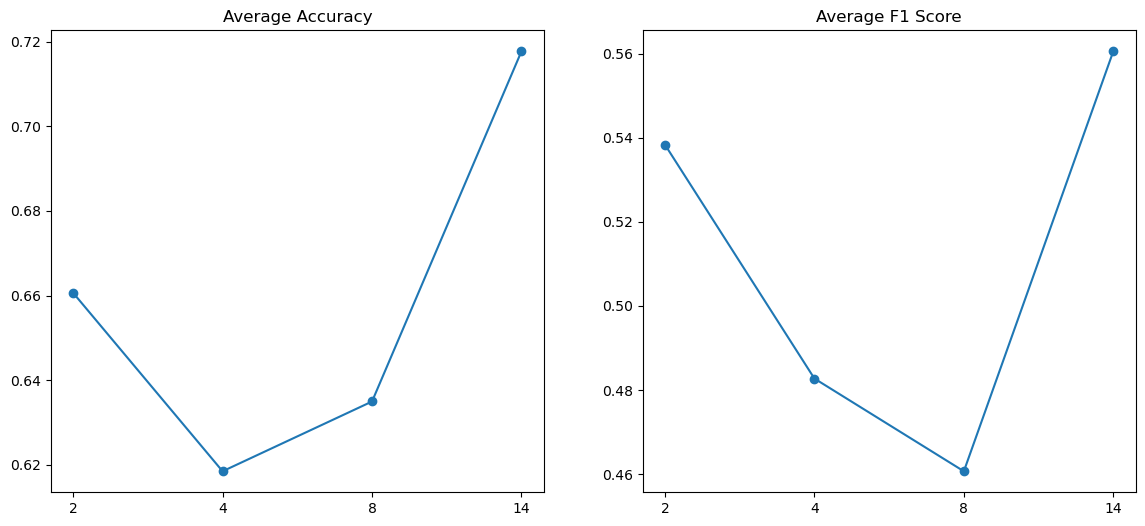

**********   Top 2   **********
Accuracy: 0.660625 +- 0.11396785456873354
F1 Score: 0.5383343039313627 +- 0.16106718376221538

**********   Top 4   **********
Accuracy: 0.6184375 +- 0.10330429489498488
F1 Score: 0.4827334425120803 +- 0.1552140275403721

**********   Top 8   **********
Accuracy: 0.6349375 +- 0.10424053838958239
F1 Score: 0.4606820695644225 +- 0.17222492410927917

**********   Top 14   **********
Accuracy: 0.71775 +- 0.10322427040187786
F1 Score: 0.560547027972028 +- 0.1781482475412024



In [ ]:
plot_metrics(ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs, ttau_mix_features)

### pTau_Positivity final results

For pTau we see that our possible best case scenario is obtained using either the `top 8 features` from the `ML approach` or the `top 8 features` from `F classif`.</br>

|             | `Accuracy`       | `F1 Score`       |
|-------------|------------------|------------------|
| `ML`        | 0.7289 +- 0.0987 | 0.5902 +- 0.1634 |
| `F classif` | 0.7353 +- 0.0993 | 0.5984 +- 0.1714 |

</br>

| `ML Features`               | `F_classif Features`      |
|-----------------------------|---------------------------|
| VP_to_AUX_VP (participant)  | # ADP (participant)       |
| VP_to_AUX (participant)     | # ADV (participant)       |
| AvgNPTypeLengthNonEmbedded  | # SCONJ (participant)     |
| # NUM (participant)         | # PART (participant)      |
| RatioNoun                   | # DET (participant)       |
| RatioVerb                   | # PRON (participant)      |
| MSTTR (participant)         | NP_to_DT_NN (participant) |
| # SCONJ (participant)       | # NUM (participant)       |

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [61]:
def load_exp(selected_feats, target, typ=int, audio=False):
    # Load the entire csv file
    data = pd.read_csv('data/full_corrected.csv' if audio else 'data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [8]:
import seaborn as sns

TTAU_EXP_FEATS_ML = [
    'VP_to_AUX_VP (participant)',
    'VP_to_AUX (participant)',
    'AvgNPTypeLengthNonEmbedded',
    '# NUM (participant)',
    'RatioNoun',
    'RatioVerb',
    'MSTTR (participant)',
    '# SCONJ (participant)'
]

TTAU_EXP_FEATS_F_CLASS = [
    '# ADP (participant)',
    '# ADV (participant)',
    '# SCONJ (participant)',
    '# PART (participant)',
    '# DET (participant)',
    '# PRON (participant)',
    'NP_to_DT_NN (participant)',
    '# NUM (participant)'
]

TARGETS = ['ML Approach', 'F_classif Approach']

## Variable Correlation

In [88]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target, name) in enumerate(zip([TTAU_EXP_FEATS_ML, TTAU_EXP_FEATS_F_CLASS], ['pTau_Positivity', 'pTau_Positivity'], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)
        corr_target.rename(name)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[name]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[name]))
    return series, annots

In [89]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=2, figsize=(8,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    plt.yticks(rotation=0) 
    plt.subplots_adjust(wspace=1, top=0.92)
    plt.show()

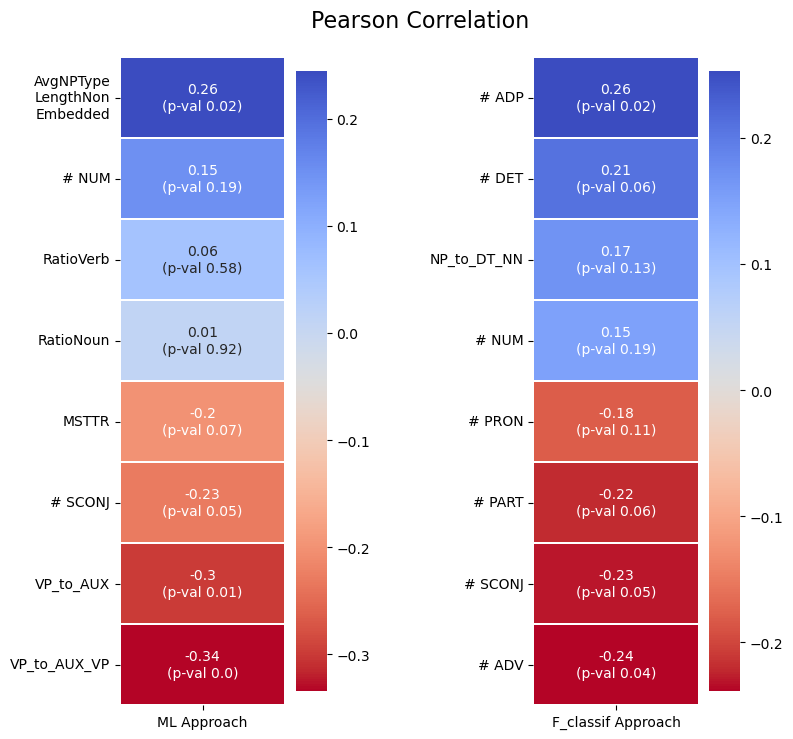

In [90]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

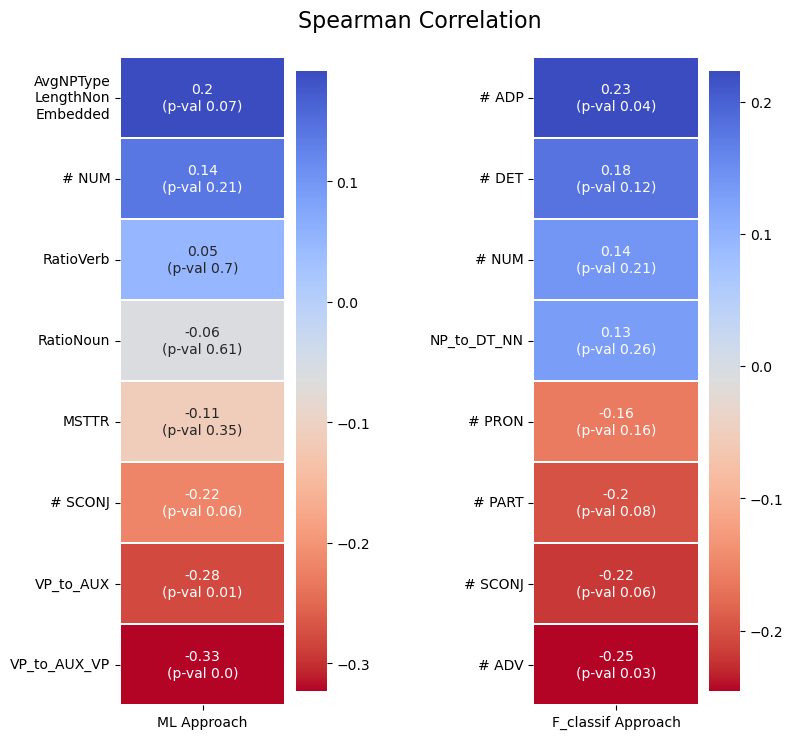

In [91]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

## Shap Values

In [62]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [63]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [64]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [66]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [67]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [68]:
def explain(target, features, cv_repetitions, seeds, audio=False):
    df = load_exp(features, target, audio=audio)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [69]:
def plot_shap_vals(X, average_values, label, cv_repetitions):
    cols = []
    for col in list(X.columns):
        if col == 'AvgNPType\nLength\nNonEmbedded':
            col = 'AvgNPTypeLength\nNonEmbedded'
        cols.append(col)
    X.columns = cols
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.xlabel('')
    plt.show()

In [70]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### pTau_Positivity (Full)

In [71]:
TTAU_SEEDS_AUDIO = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_audio, ttau_class_0_audio, ttau_class_1_audio = explain('pTau_Positivity', TTAU_ML_FULL_COMPUTED_FEATURES[:8], CV_REPETITIONS, TTAU_SEEDS_AUDIO, audio=True)

100%|██████████| 1000/1000 [15:43<00:00,  1.06it/s]


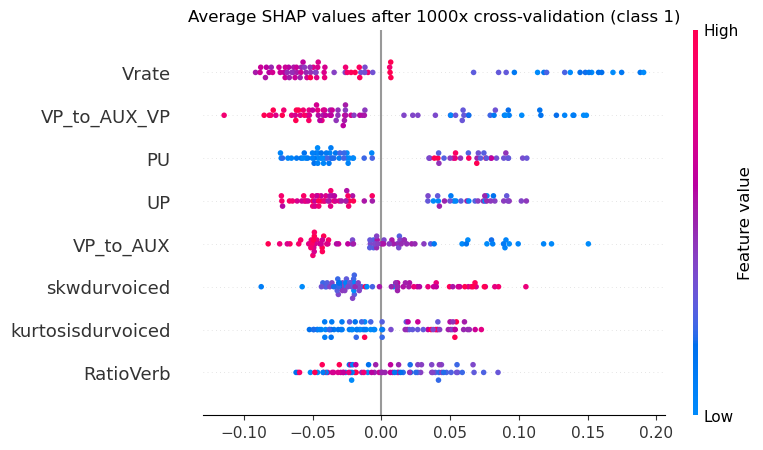

In [72]:
plot_shap_vals(X_ttau_exp_audio, ttau_class_1_audio[0], 1, CV_REPETITIONS)

### pTau_Positivity (No Audio)

In [17]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('pTau_Positivity', TTAU_EXP_FEATS_ML, CV_REPETITIONS, TTAU_SEEDS)

100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]


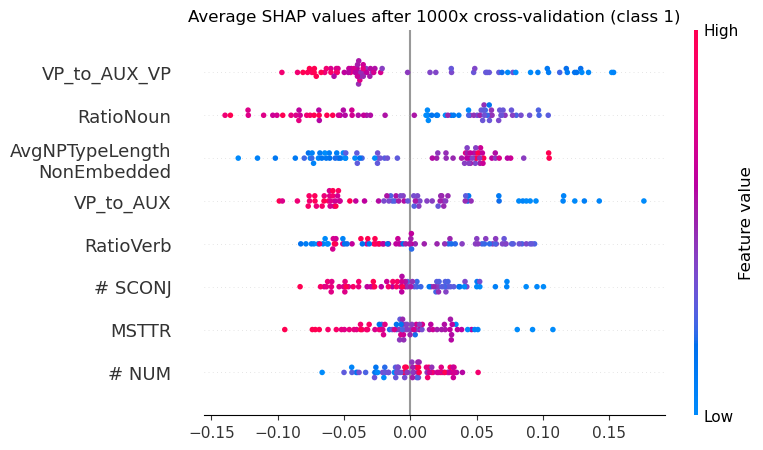

In [31]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

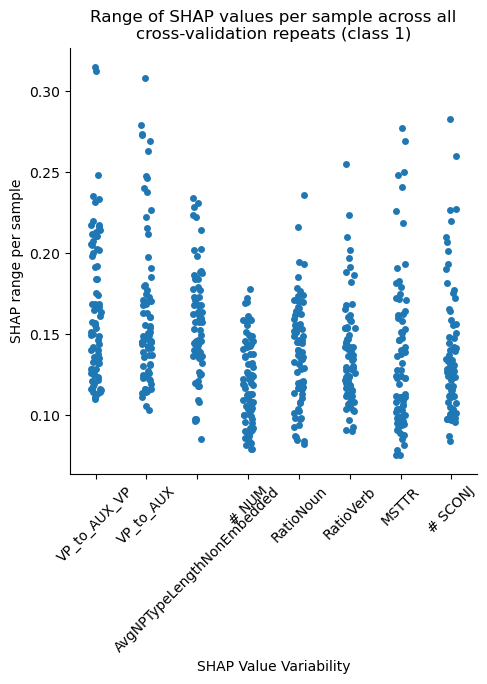

In [102]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

In [103]:
TTAU_SEEDS_f = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_f, ttau_class_0_f, ttau_class_1_f = explain('pTau_Positivity', TTAU_EXP_FEATS_F_CLASS, CV_REPETITIONS, TTAU_SEEDS_f)

100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s]


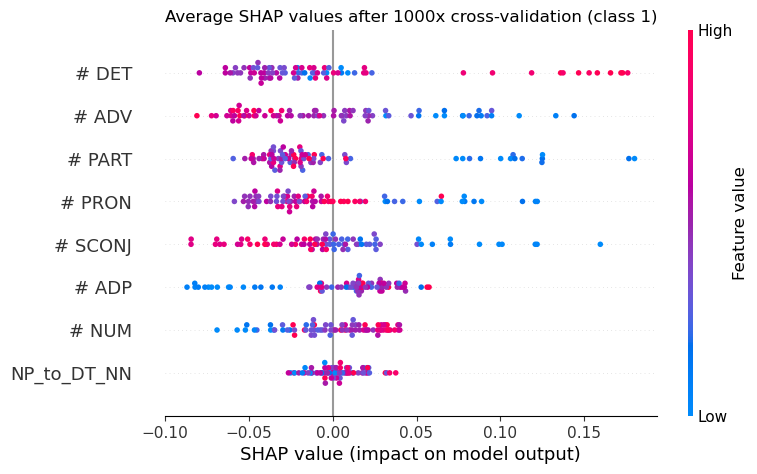

In [104]:
plot_shap_vals(X_ttau_exp_f, ttau_class_1_f[0], 1, CV_REPETITIONS)

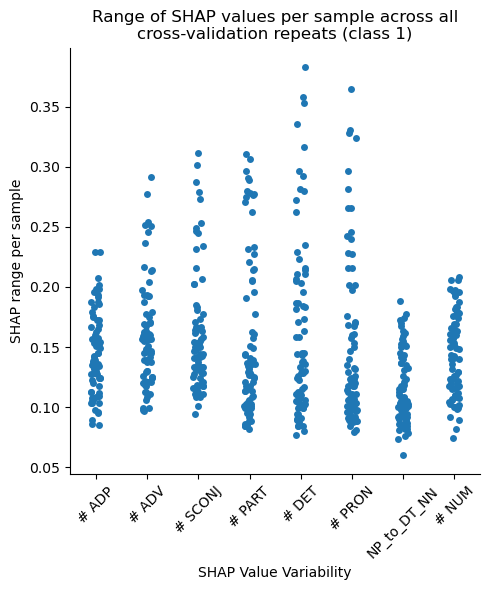

In [105]:
plot_ranges(X_ttau_exp_f, ttau_class_1_f[2], 1)